## Load MODIS file(s)

In [4]:
import tifffile as tiff
import numpy as np
#from PIL import Image
#Image.MAX_IMAGE_PIXELS = 1000000000
import matplotlib.pyplot as plt
from osgeo import gdal
from osgeo_utils import gdal_merge
gdal.UseExceptions()

In [5]:
modis_tower_path = "/home/mxh/MODIS_MOD09GA_GERITAFRA_31day_DEC2023/"
modis_volume_path="/media/mxh/Volume/SAT-DATA/MODIS_MOD09GA_GERITAFRA_31day_DEC2023/"
modis_win_path = "F:\\Bachelorarbeit\\sat-data\\modis\\MODIS_MOD09GA_GERITAFRA_31day_DEC2023\\"
modis_x_path = "/mnt/f/Bachelorarbeit/SAT-DATA/MODIS_MOD09GA_GERITAFRA_31day_DEC2023/"
modis_path = modis_tower_path
day1 = "MOD09GA.A2023335.h18v04.061.2023340033530"

# Definitionen

In [6]:
def merge_MOD09GA_refl_bands_to_tif(path, filename, size=2400, extension=".hdf"):
    """
    filename without .hdf file extension!
    """
    f= gdal.Open(path+filename+extension)
    subsets = f.GetSubDatasets()
    driver = subsets[11][0][:-3] # get common driver command # cant i just loop over drivers??
    # Reorder bands to fit the L8 order. The model is trained on this order.
    L8_order = [3, 4, 1, 2, 6, 7, 5] # [2, 3, 0, 1, 5, 6, 4] # landsat8 order of modis (modga09) bands
    # remember to +1 every band as MODIS starts its bands at index 1
    for i in L8_order:  # translate bands 1-7 to geotiff
        """ 
        Order like this:              (L8                   , MODGA09)
        fmask_config.setReflectiveBand(fmask.config.BAND_RED, 0)
        fmask_config.setReflectiveBand(fmask.config.BAND_NIR, 1)
        fmask_config.setReflectiveBand(fmask.config.BAND_BLUE, 2)
        fmask_config.setReflectiveBand(fmask.config.BAND_GREEN, 3)
        fmask_config.setReflectiveBand(fmask.config.BAND_CIRRUS, 4)
        fmask_config.setReflectiveBand(fmask.config.BAND_SWIR1, 5)
        fmask_config.setReflectiveBand(fmask.config.BAND_SWIR2, 6)
        """
        """
        Landsat 8 Order MODIS bands:

        L8 | MODGA09
        1  |  x      | COASTAL / AEROSOL
        2  |  3      | BLUE
        3  |  4      | GREEN
        4  |  1      | RED
        5  |  2      | NIR
        6  |  6      | SWIR1
        7  |  7      | SWIR2
        8  |  x      | PANCHROMATIC
        9  |  5      | CIRRUS
        10 |  x      | LWIR1
        11 |  x      | LWIR2

        Order: 3, 4, 1, 2, 6, 7, 5
        """
        driveri = driver + str(i) +'_1'
        band = gdal.Open(driveri)
        gdal.Translate(destName=f'{modis_path+filename}_b{i}_{size}.tiff', srcDS=band, format="GTiff", width=size, height=size)
    
    #gdal.Warp(destNameOrDestDS=path+filename+'_warped.tif', srcDSOrSrcDSTab=[f'{path+filename}_b{i}.tif' for i in range(1,7+1)])
    
    # merge_params = ['', '-separate']+[f'{path+filename}_b{i}.tif' for i in range(1,7+1)]+['-o', path+filename+'_merged.tif']
    merge_params = ['', '-separate']+[f'{path+filename}_b{i}_{size}.tiff' for i in L8_order]+['-o', path+filename+f'_merged_{size}.tiff']
    gdal_merge.main(merge_params)
    #!{gdal_path}gdal_merge.py -separate {modis_path+day1}_b[1-7].tif -o {modis_path+day1}_merged.tif

In [7]:
def warp_MOD09GA_to_epsg(path, filename, postfix="_wgs84_warped", SRS="EPSG:4326", translate=True):
    """
    filename: without .tiff extension
    """
    warp_options = gdal.WarpOptions(dstSRS=SRS)
    warp = gdal.Warp(destNameOrDestDS=path+filename+postfix+".tmp.tiff", srcDSOrSrcDSTab=path+filename+".tiff", options=warp_options)
    if translate:
        gdal.Translate(destName=path+filename+postfix+".tiff", srcDS=warp, format="GTiff") # , creationOptions=['TILED:YES']
    warp = None

In [8]:
def upscale_single_layer(path, filename, name, driver, size=2400):
    # upscale gdal
    translate_opts = {"format": "GTiff", "resampleAlg": "nearest", "width": size, "height": size} #,"creationOptions": ['TILED:YES']}
    # resampleAlgs -r {nearest|bilinear|cubic|cubicspline|lanczos|average|rms|mode}
    gdal.Translate(path + filename + f"_{name}_{size}.tiff", driver, **translate_opts)

In [9]:
def upscale_all_angle_layers(path, filename, size=2400):
    # need to be sorted like so:
    drivers = {"solar_zenith": f'HDF4_EOS:EOS_GRID:"{path}{filename}.hdf":MODIS_Grid_1km_2D:SolarZenith_1',
               "solar_azimuth": f'HDF4_EOS:EOS_GRID:"{path}{filename}.hdf":MODIS_Grid_1km_2D:SolarAzimuth_1',
               "sensor_zenith": f'HDF4_EOS:EOS_GRID:"{path}{filename}.hdf":MODIS_Grid_1km_2D:SensorZenith_1',
               "sensor_azimuth": f'HDF4_EOS:EOS_GRID:"{path}{filename}.hdf":MODIS_Grid_1km_2D:SensorAzimuth_1'}

    for k in drivers.keys():
        upscale_single_layer(path, filename, name=k, driver=drivers[k], size=size)

    merge_params = ['', '-separate']+[(path + filename + f"_{name}_{size}.tiff") for name in drivers.keys()]+['-o', path+filename+f'_upscaled_angles_{size}.tiff']
    gdal_merge.main(merge_params)

# Do Prep for multiple defined days:

#### Steps
1.1 Mergen zu Merged1-7, dabei Projection + Geometry beibehalten

1.2 Warpen zu _wgs84.tif

2.1 Upscalen der Solar/Sensor Zenith/Azimuth Layers zu 2400x2400 bzw. um Faktor 2,  dabei Projection + Geometry beibehalten

2.2 Warpen zu _wgs84.tif

3. Siehe sis_RunFmaskOnMODIS.ipynb

3.1 Input der Dateien und Bänder-Zuordnung in Fmask Config Objekte

3.2 Run Fmask

4 Upsample der State1km Datei und rewarp zu wgs84

In [10]:
modis_path = modis_path
curr_size=2400

In [8]:
days = {0: "MOD09GA.A2023335.h18v04.061.2023340033530.hdf",
1: "MOD09GA.A2023336.h18v04.061.2023338023416.hdf",
2: "MOD09GA.A2023337.h18v04.061.2023339023523.hdf",
3: "MOD09GA.A2023338.h18v04.061.2023340034455.hdf", 
4: "MOD09GA.A2023339.h18v04.061.2023341041457.hdf",
5: "MOD09GA.A2023340.h18v04.061.2023342030232.hdf",
6: "MOD09GA.A2023341.h18v04.061.2023343024753.hdf",
7: "MOD09GA.A2023342.h18v04.061.2023344024915.hdf",
8: "MOD09GA.A2023343.h18v04.061.2023345024918.hdf"}

In [11]:
days = {0: "MOD09GA.A2023335.h18v04.061.2023340033530.hdf",
1: "MOD09GA.A2023336.h18v04.061.2023338023416.hdf",
2: "MOD09GA.A2023337.h18v04.061.2023339023523.hdf",
3: "MOD09GA.A2023338.h18v04.061.2023340034455.hdf", 
4: "MOD09GA.A2023339.h18v04.061.2023341041457.hdf",
5: "MOD09GA.A2023340.h18v04.061.2023342030232.hdf",
6: "MOD09GA.A2023341.h18v04.061.2023343024753.hdf",
7: "MOD09GA.A2023342.h18v04.061.2023344024915.hdf",
8: "MOD09GA.A2023343.h18v04.061.2023345024918.hdf",
9: "MOD09GA.A2023344.h18v04.061.2023346030519.hdf",
10: "MOD09GA.A2023345.h18v04.061.2023347025532.hdf",
11: "MOD09GA.A2023346.h18v04.061.2023348030312.hdf",
12: "MOD09GA.A2023347.h18v04.061.2023349025736.hdf",
13: "MOD09GA.A2023348.h18v04.061.2023350024202.hdf",
14: "MOD09GA.A2023349.h18v04.061.2023351023935.hdf",
15: "MOD09GA.A2023350.h18v04.061.2023352030330.hdf",
16: "MOD09GA.A2023351.h18v04.061.2023353030525.hdf",
17: "MOD09GA.A2023352.h18v04.061.2023354042819.hdf",
18: "MOD09GA.A2023353.h18v04.061.2023355063849.hdf",
19: "MOD09GA.A2023354.h18v04.061.2023356042206.hdf",
20: "MOD09GA.A2023355.h18v04.061.2023357031321.hdf",
21: "MOD09GA.A2023356.h18v04.061.2023361000333.hdf",
22: "MOD09GA.A2023357.h18v04.061.2023359024858.hdf",
23: "MOD09GA.A2023358.h18v04.061.2023360025923.hdf",
24: "MOD09GA.A2023359.h18v04.061.2023361050233.hdf",
25: "MOD09GA.A2023360.h18v04.061.2023362134719.hdf",
26: "MOD09GA.A2023361.h18v04.061.2023363043955.hdf",
27: "MOD09GA.A2023362.h18v04.061.2023364042452.hdf",
28: "MOD09GA.A2023363.h18v04.061.2023365041515.hdf",
29: "MOD09GA.A2023364.h18v04.061.2024001025343.hdf",
30: "MOD09GA.A2023365.h18v04.061.2024004181336.hdf"
}

In [12]:
for i, (k, filename) in enumerate(days.items()):
    day = filename[:-4] # without file extension
    #step 1
    merge_MOD09GA_refl_bands_to_tif(modis_path, day, size=curr_size)
    warp_MOD09GA_to_epsg(modis_path, day+f"_merged_{curr_size}")
    
    #step 2
    upscale_all_angle_layers(modis_path, day, size=curr_size)
    
    warp_MOD09GA_to_epsg(modis_path, filename=day+f"_upscaled_angles_{curr_size}")
    angles = ["solar_zenith", "solar_azimuth", "sensor_zenith", "sensor_azimuth"]
    for a in angles:  # also warp all individual angle files, for Fmask AnglesFileInfo input
        warp_MOD09GA_to_epsg(modis_path, filename=day+"_"+a+"_"+str(curr_size))
    
    #step 3
    # done in fmask notebook

    #step 4
    driver = f'HDF4_EOS:EOS_GRID:"{modis_path}{day}.hdf":MODIS_Grid_1km_2D:state_1km_1'
    upscale_single_layer(modis_path, day, name="state_1km_1", driver=driver, size=curr_size)
    warp_MOD09GA_to_epsg(modis_path, day+f"_state_1km_1_{curr_size}")

0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...

### Output files are:


# MISC

## Rewarp to Original Sinusoidal

In [ ]:
og_srs = 'PROJCS["unnamed",GEOGCS["Unknown datum based upon the custom spheroid",DATUM["Not specified (based on custom spheroid)",SPHEROID["Custom spheroid",6371007.181,0]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Sinusoidal"],PARAMETER["longitude_of_center",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'


In [ ]:
warp_MOD09GA_to_epsg(path=modis_path, filename="MOD09GA.A2023335.h18v04.061.2023340033530_merged_2400_wgs84_warped", postfix="_og_srs" ,SRS=og_srs)

#### Test if rewarp worked

In [ ]:
ds = gdal.Open(modis_path+"MOD09GA.A2023335.h18v04.061.2023340033530_merged_2400_wgs84_warped_og_srs.tiff")
data = ds.ReadAsArray()

In [24]:
data.shape # shape of (7,2400,2400)

(7, 2454, 2924)

In [ ]:
ds.GetProjection()

'PROJCS["unnamed",GEOGCS["Unknown datum based upon the custom spheroid",DATUM["Not_specified_based_on_custom_spheroid",SPHEROID["Custom spheroid",6371007.181,0]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Sinusoidal"],PARAMETER["longitude_of_center",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'

In [122]:
day1_hdf = gdal.Open(modis_path + day1 + '.hdf')
day1_subsets = day1_hdf.GetSubDatasets()

In [123]:
day1_subsets

[('HDF4_EOS:EOS_GRID:"/media/mxh/Volume/SAT-DATA/MODIS_MOD09GA_GERITAFRA_31day_DEC2023/MOD09GA.A2023335.h18v04.061.2023340033530.hdf":MODIS_Grid_1km_2D:num_observations_1km',
  '[1200x1200] num_observations_1km MODIS_Grid_1km_2D (8-bit integer)'),
 ('HDF4_EOS:EOS_GRID:"/media/mxh/Volume/SAT-DATA/MODIS_MOD09GA_GERITAFRA_31day_DEC2023/MOD09GA.A2023335.h18v04.061.2023340033530.hdf":MODIS_Grid_1km_2D:state_1km_1',
  '[1200x1200] state_1km_1 MODIS_Grid_1km_2D (16-bit unsigned integer)'),
 ('HDF4_EOS:EOS_GRID:"/media/mxh/Volume/SAT-DATA/MODIS_MOD09GA_GERITAFRA_31day_DEC2023/MOD09GA.A2023335.h18v04.061.2023340033530.hdf":MODIS_Grid_1km_2D:SensorZenith_1',
  '[1200x1200] SensorZenith_1 MODIS_Grid_1km_2D (16-bit integer)'),
 ('HDF4_EOS:EOS_GRID:"/media/mxh/Volume/SAT-DATA/MODIS_MOD09GA_GERITAFRA_31day_DEC2023/MOD09GA.A2023335.h18v04.061.2023340033530.hdf":MODIS_Grid_1km_2D:SensorAzimuth_1',
  '[1200x1200] SensorAzimuth_1 MODIS_Grid_1km_2D (16-bit integer)'),
 ('HDF4_EOS:EOS_GRID:"/media/mxh/Vol

In [31]:
day1_state_1km = gdal.Open(f'HDF4_EOS:EOS_GRID:"{modis_path}MOD09GA.A2023335.h18v04.061.2023340033530.hdf":MODIS_Grid_1km_2D:state_1km_1')
day1_sur_refl_b04 = gdal.Open(f'HDF4_EOS:EOS_GRID:"{modis_path}MOD09GA.A2023335.h18v04.061.2023340033530.hdf":MODIS_Grid_500m_2D:sur_refl_b04_1')
day1_sur_refl_b05 = gdal.Open(f'HDF4_EOS:EOS_GRID:"{modis_path}MOD09GA.A2023335.h18v04.061.2023340033530.hdf":MODIS_Grid_500m_2D:sur_refl_b05_1')

In [33]:
day1_state_1km.ReadAsArray().shape

(1200, 1200)

In [4]:
day1_state_1km.GetMetadata()

{'ADDITIONALLAYERS1KM': '12',
 'ADDITIONALLAYERS500M': '1',
 'ASSOCIATEDINSTRUMENTSHORTNAME.1': 'MODIS',
 'ASSOCIATEDPLATFORMSHORTNAME.1': 'Terra',
 'ASSOCIATEDSENSORSHORTNAME.1': 'MODIS',
 'AUTOMATICQUALITYFLAG.1': 'Passed',
 'AUTOMATICQUALITYFLAGEXPLANATION.1': 'No automatic quality assessment is performed in the PGE',
 'CHARACTERISTICBINANGULARSIZE1KM': '30.0',
 'CHARACTERISTICBINANGULARSIZE500M': '15.0',
 'CHARACTERISTICBINSIZE1KM': '926.625433055556',
 'CHARACTERISTICBINSIZE500M': '463.312716527778',
 'CLOUDOPTION': 'MOD09 internally-derived',
 'COVERAGECALCULATIONMETHOD': 'volume',
 'COVERAGEMINIMUM': '0.00999999977648258',
 'DATACOLUMNS1KM': '1200',
 'DATACOLUMNS500M': '2400',
 'DATAROWS1KM': '1200',
 'DATAROWS500M': '2400',
 'DAYNIGHTFLAG': 'Day',
 'DEEPOCEANFLAG': 'Yes',
 'DESCRREVISION': '6.1',
 'EASTBOUNDINGCOORDINATE': '15.5702026309755',
 'EQUATORCROSSINGDATE.1': '2023-12-01',
 'EQUATORCROSSINGDATE.2': '2023-12-01',
 'EQUATORCROSSINGLONGITUDE.1': '12.9972560548935',
 'EQUA

## try a BITSHIFT to display clouds/cirrus etc. (info in versuch_ablauf.md)

In [32]:

# shift probably still contains all info from the remaining lower significant bits (yes, true)
#shift_by = 5
#internal_cloud_algo_res = np.left_shift(day1_state_1km.ReadAsArray().copy(), shift_by)

# so we try a bitmask: (further info in versuch_ablauf.md)
# length 16!
pixel_adjacent_to_cloud     = 0b0010000000000000
internal_cloud_algo_bitmask = 0b0000010000000000
cirrus_detected             = 0b0000001100000000
cloud_shadow                = 0b0000000000000100
cloud_state                 = 0b0000000000000011


In [33]:

res = day1_state_1km.ReadAsArray().copy() & internal_cloud_algo_bitmask

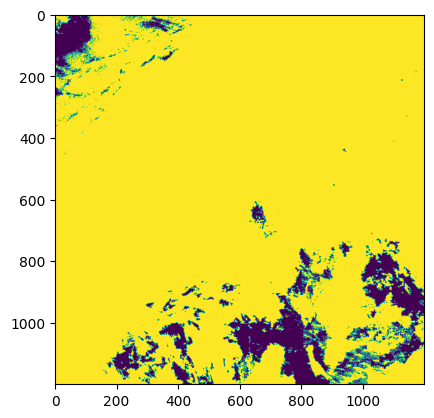

In [34]:
fig, ax = plt.subplots(1,1)
ax.imshow(res)
## show state 1km

In [37]:
# test for warped state1km
day1_warped_state1km = gdal.Open(modis_path+"MOD09GA.A2023335.h18v04.061.2023340033530_state_1km_1_2400_wgs84_warped.tiff")
day1_warped_state1km

<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x76040ee9a490> >

In [50]:
res = day1_warped_state1km.ReadAsArray().copy() #& internal_cloud_algo_bitmask

In [53]:
res[2063][3210]

65535

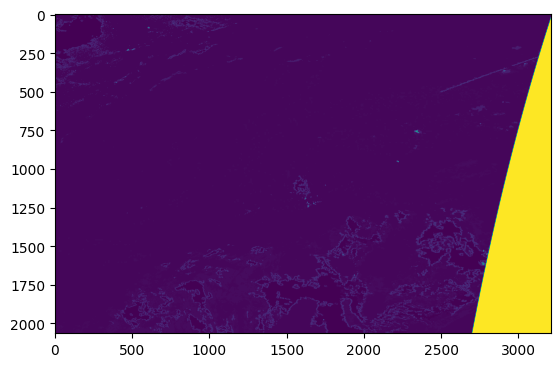

In [52]:
fig, ax = plt.subplots(1,1)
ax.imshow(res)
## show state 1km

### plot for vis

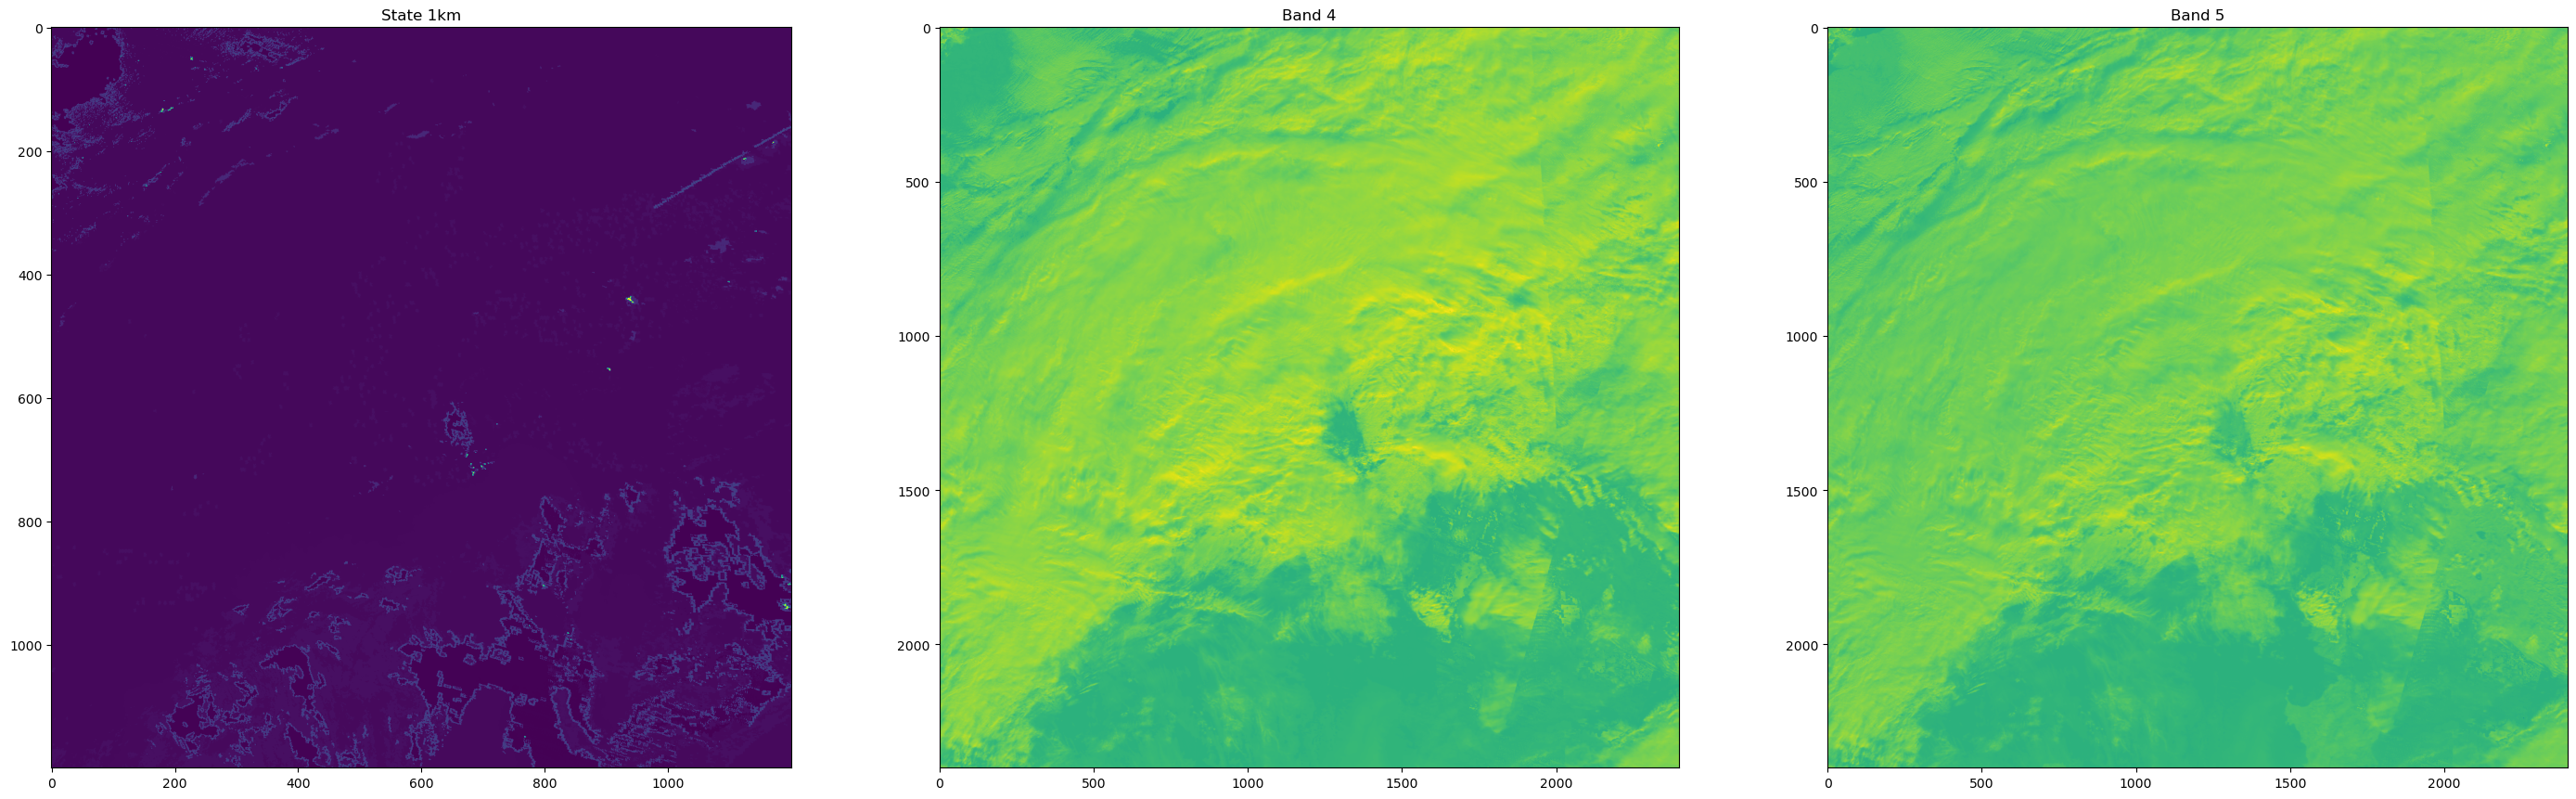

In [127]:
plt.figure(figsize=(35, 35))

plt.subplot(1, 3, 1)
plt.title('State 1km' )
plt.imshow(day1_state_1km.ReadAsArray())

plt.subplot(1, 3, 2)
plt.title('Band 4')
plt.imshow(day1_sur_refl_b04.ReadAsArray())

plt.subplot(1, 3, 3)
plt.title('Band 5' )
plt.imshow(day1_sur_refl_b05.ReadAsArray())

plt.show()

In [128]:
# convert to TIFF for Unet input?


# copy toa func from sis_GenerateBiome_TOA notebook
def _create_toa_file_MODIS(data_path, toa_path):
    print('Processing product: ' + data_path +' into ' + toa_path)
    !{gdal_path}gdal_merge.py -separate -of HFA -co COMPRESSED=YES -o {data_path}ref.img {data_path}LC8*_B[1-7,9].TIF
    !{gdal_path}gdal_merge.py -separate -of HFA -co COMPRESSED=YES -o {data_path}thermal.img {data_path}LC8*_B1[0,1].TIF
    
    !{fmask_path}fmask_usgsLandsatMakeAnglesImage.py -m {data_path}*_MTL.txt -t {data_path}ref.img -o {data_path}angles.img                
    !{fmask_path}fmask_usgsLandsatSaturationMask.py -i {data_path}ref.img -m {data_path}*_MTL.txt -o {data_path}saturationmask.img
    !mkdir -p {toa_path}
    !{fmask_path}fmask_usgsLandsatTOA.py -i {data_path}ref.img -m {data_path}*_MTL.txt -z {data_path}angles.img -o {data_path}toa.img        

    # Translate to .tif file
    !{gdal_path}gdal_translate -of Gtiff {data_path}toa.img {toa_path + data_path[-22:-1]}_toa.TIF

    # Delete all intermediate files
    !rm {data_path}*.img {data_path}*.xml

# plan is to create TOA file for MODIS file, as this will be needed for Unet prediction
# https://semiautomaticclassificationmanual.readthedocs.io/en/latest/tutorial_1.html
    # https://modis.gsfc.nasa.gov/data/atbd/atbd_mod11.pdf

In [129]:
# create TOA with GDAL, save to TIFF

# get raster band(s)
band_number = 1
#band1 = gdal.Open(f'HDF4_EOS:EOS_GRID:"/media/mxh/Volume/SAT-DATA/MODIS_MOD09GA_GERITAFRA_31day_DEC2023/MOD09GA.A2023335.h18v04.061.2023340033530.hdf":MODIS_Grid_500m_2D:sur_refl_b0{band_number}_1')
#band1_surface_refl = band1.ReadAsArray()

# retrieve sensor zenith angle 
sensor_zenith_angle = gdal.Open(f'HDF4_EOS:EOS_GRID:"{modis_path}MOD09GA.A2023335.h18v04.061.2023340033530.hdf":MODIS_Grid_1km_2D:SensorZenith_1')
sensor_zenith_angle = sensor_zenith_angle.ReadAsArray()


# retrieve solar zenith angle 
solar_zenith_angle = gdal.Open(f'HDF4_EOS:EOS_GRID:"{modis_path}MOD09GA.A2023335.h18v04.061.2023340033530.hdf":MODIS_Grid_1km_2D:SolarZenith_1')
solar_zenith_angle =solar_zenith_angle.ReadAsArray()

## GDAL Merging / Translating
1. Translate all individual bands (1-7) 

### Merge Bands

In [130]:
from osgeo_utils import gdal_merge

In [1]:
# merge modis refl bands 1-7 into new tif file

# def merge_modis_modGA09_refl_bands_to_tif(path, filename):
#     """
#     filename without .hdf file extension!
#     """
#     f= gdal.Open(path+filename+'.hdf')
#     subsets = f.GetSubDatasets()
#     driver = subsets[11][0][:-3] # get common driver command
#     for i in range(1,7+1):  # translate bands 1-7 to geotiff
#         driveri = driver + str(i) +'_1'
#         band = gdal.Open(driveri)
#         gdal.Translate(destName=f'{modis_path+filename}_b{i}.tif', srcDS=band, format="GTiff")
    
#     #gdal.Warp(destNameOrDestDS=path+filename+'_warped.tif', srcDSOrSrcDSTab=[f'{path+filename}_b{i}.tif' for i in range(1,7+1)])
    
#     # merge_params = ['', '-separate']+[f'{path+filename}_b{i}.tif' for i in range(1,7+1)]+['-o', path+filename+'_merged.tif']
#     merge_params = ['', '-separate']+[f'{path+filename}_b{i}.tif' for i in range(1,7+1)]+['-o', path+filename+'_merged.tif']
#     gdal_merge.main(merge_params)
#     #!{gdal_path}gdal_merge.py -separate {modis_path+day1}_b[1-7].tif -o {modis_path+day1}_merged.tif

In [2]:
def merge_modis_modGA09_refl_bands_to_tif(path, filename, size=256):
    """
    filename without .hdf file extension!
    """
    f= gdal.Open(path+filename+'.hdf')
    subsets = f.GetSubDatasets()
    driver = subsets[11][0][:-3] # get common driver command
    for i in range(1,7+1):  # translate bands 1-7 to geotiff
        driveri = driver + str(i) +'_1'
        band = gdal.Open(driveri)
        gdal.Translate(destName=f'{modis_path+filename}_b{i}_{size}.tif', srcDS=band, format="GTiff", width=size, height=size)
    
    #gdal.Warp(destNameOrDestDS=path+filename+'_warped.tif', srcDSOrSrcDSTab=[f'{path+filename}_b{i}.tif' for i in range(1,7+1)])
    
    # merge_params = ['', '-separate']+[f'{path+filename}_b{i}.tif' for i in range(1,7+1)]+['-o', path+filename+'_merged.tif']
    merge_params = ['', '-separate']+[f'{path+filename}_b{i}_{size}.tif' for i in range(1,7+1)]+['-o', path+filename+f'_merged_{size}.tif']
    gdal_merge.main(merge_params)
    #!{gdal_path}gdal_merge.py -separate {modis_path+day1}_b[1-7].tif -o {modis_path+day1}_merged.tif

In [12]:
merge_modis_modGA09_refl_bands_to_tif(modis_path, day1, size=2400)

0...10...20...30...40...50...60...70...80...90...100 - done.


In [86]:
merge_modis_modGA09_refl_bands_to_tif(modis_path, day1)

0...10...20...30...40...50...60...70...80...90...100 - done.


In [133]:
print("Solar zenith angle")
solar_zenith_angle

Solar zenith angle


array([[7384, 7383, 7383, ..., 7611, 7611, 7611],
       [7383, 7383, 7382, ..., 7610, 7611, 7611],
       [7382, 7382, 7381, ..., 7610, 7610, 7610],
       ...,
       [6426, 6425, 6425, ..., 6799, 6798, 6798],
       [6425, 6425, 6424, ..., 6798, 6796, 6796],
       [6424, 6424, 6423, ..., 6798, 6796, 6796]], dtype=int16)

In [134]:
print("Sensor zenith angle")
sensor_zenith_angle


Sensor zenith angle


array([[ 909,  900,  891, ..., 5166, 5166, 5166],
       [ 909,  900,  891, ..., 5166, 5166, 5166],
       [ 908,  899,  890, ..., 5166, 5166, 5166],
       ...,
       [1560, 1569, 1569, ..., 5403, 5393, 5392],
       [1559, 1569, 1578, ..., 5403, 5393, 5393],
       [1559, 1569, 1578, ..., 5403, 5393, 5392]], dtype=int16)

In [16]:
from scipy.interpolate import RegularGridInterpolator, NearestNDInterpolator

In [17]:
solar_zenith_angle.shape

(1200, 1200)

### Upscale Solar Zenith Angle SZA

In [135]:
# upscale gdal
translate_opts = {"format": "GTiff", "resampleAlg": "cubic", "width": "2400", "height": "2400"}
# resampleAlgs -r {nearest|bilinear|cubic|cubicspline|lanczos|average|rms|mode}
gdal.Translate(modis_path + day1 + "_solar_za_upscaled.tif", f'HDF4_EOS:EOS_GRID:"{modis_path}{day1}.hdf":MODIS_Grid_1km_2D:SolarZenith_1', **translate_opts)

<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x7f21c1a32700> >

In [140]:
translate_opts = {"format": "GTiff", "resampleAlg": "cubic", "width": "256", "height": "256"}
# resampleAlgs -r {nearest|bilinear|cubic|cubicspline|lanczos|average|rms|mode}
gdal.Translate(modis_path + day1 + "_solar_za_ds_256.tif", f'HDF4_EOS:EOS_GRID:"{modis_path}{day1}.hdf":MODIS_Grid_1km_2D:SolarZenith_1', **translate_opts)

<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x7f21c2948d50> >

In [147]:
translate_opts = {"format": "GTiff", "resampleAlg": "cubic", "width": "256", "height": "256"}
# resampleAlgs -r {nearest|bilinear|cubic|cubicspline|lanczos|average|rms|mode}
gdal.Translate(modis_path + day1 + "_sensor_za_ds_256.tif", f'HDF4_EOS:EOS_GRID:"{modis_path}{day1}.hdf":MODIS_Grid_1km_2D:SensorZenith_1', **translate_opts)

<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x7f21c1435a40> >

In [137]:
def upscale_nn(original_array_copy, scale_factor=2):
    upscaled_array = np.repeat(np.repeat(original_array_copy, scale_factor, axis=0), scale_factor, axis=1)
    # Create an index grid for the upscaled array
    x, y = np.meshgrid(np.arange(upscaled_array.shape[1]), np.arange(upscaled_array.shape[0]))

    # Find non-missing values (assuming missing values are NaN)
    valid_indices = ~np.isnan(upscaled_array)

    # Create an interpolator
    interp = NearestNDInterpolator((x[valid_indices], y[valid_indices]), upscaled_array[valid_indices])

    # Evaluate the interpolator at all points
    interpolated_values = interp(x, y)

    # Replace missing values with interpolated values
    upscaled_array[np.isnan(upscaled_array)] = interpolated_values[np.isnan(upscaled_array)]

    return upscaled_array

In [150]:
downscaled_256_solar_za = gdal.Open(modis_path + day1 + "_solar_za_ds_256.tif").ReadAsArray()

In [151]:
downscaled_256_sensor_za = gdal.Open(modis_path + day1 + "_sensor_za_ds_256.tif").ReadAsArray()

In [139]:
upscaled_sza = upscale_nn(solar_zenith_angle)

upscaled_sza = gdal.Open(modis_path + day1 + "_solar_za_upscaled.tif").ReadAsArray()  # upscale seems to have a bug. MIN_INT value passed
upscaled_sza

array([[  7384,   7384,   7383, ...,   7611,   7611,   7611],
       [  7384,   7384,   7383, ...,   7611,   7611,   7611],
       [  7383,   7383,   7383, ...,   7611,   7611,   7611],
       ...,
       [-32767, -32767, -32767, ..., -32767, -32767, -32767],
       [-32767, -32767, -32767, ..., -32767, -32767, -32767],
       [-32767, -32767, -32767, ..., -32767, -32767, -32767]], dtype=int16)

In [152]:
# convert degree to radians for zenith(s)
solar_zenith_angle_rad = np.deg2rad(upscaled_sza)
downscaled_256_solar_za_rad = np.deg2rad(downscaled_256_solar_za)
downscaled_256_sensor_za_rad = np.deg2rad(downscaled_256_sensor_za)

In [25]:
# calc TOA reflectance:
#toa_refl_band = band_surface_refl * np.cos(solar_zenith_angle_rad)
#toa_refl_band = band_surface_refl * np.sin(sensor_zenith_angle_rad)

In [143]:
# toa calc for every band
merged_day1 = gdal.Open(modis_path + day1 + '_merged_256.tif').ReadAsArray()
merged_day1

array([[[ 4799,  4437,  3123, ...,  5460,  5632,  5849],
        [ 4032,  2774,  5245, ...,  5723,  5254, 10676],
        [11378,  4611,  5795, ...,  6126,  6649,  7743],
        ...,
        [ 1622,  1552,  1337, ...,  7600,  7611,  7770],
        [ 1267,  1697,  2771, ...,  7679,  7757,  8061],
        [ 7069,  5766,  4676, ...,  6548,  6513,  7165]],

       [[ 4717,  4295,  2991, ...,  5339,  5551,  5796],
        [ 3884,  2690,  5066, ...,  5642,  5197, 10514],
        [11670,  4544,  5870, ...,  5981,  6476,  7570],
        ...,
        [ 2149,  2220,  2264, ...,  7397,  7459,  7623],
        [ 1860,  2174,  3022, ...,  7473,  7597,  7842],
        [ 7332,  5872,  4655, ...,  6421,  6407,  6999]],

       [[ 5097,  4867,  3638, ...,  5258,  5427,  5679],
        [ 4215,  2965,  5449, ...,  5548,  5178, 11180],
        [10303,  4748,  5868, ...,  5931,  6453,  7501],
        ...,
        [ 1671,  1570,  1181, ...,  7291,  7335,  7492],
        [ 1266,  1683,  2913, ...,  7275,  73

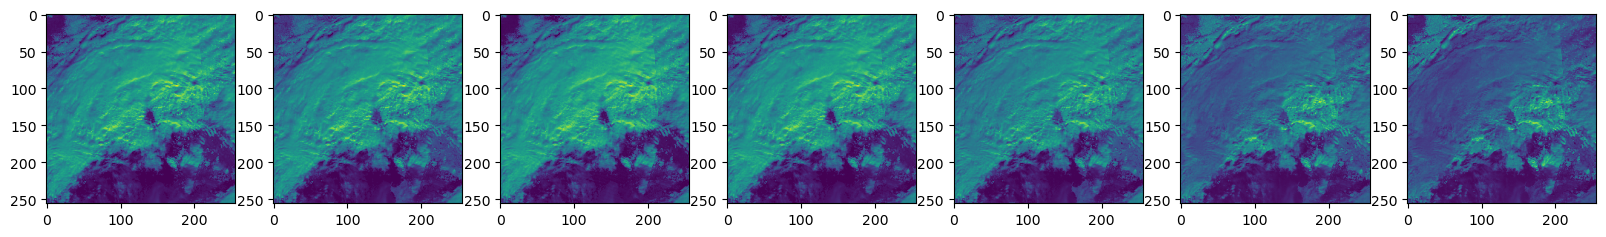

In [144]:
fig, axes = plt.subplots(1,7, figsize=(20,20))
for i, ax in enumerate(axes.flat):
    #ax.imshow(merged_day1)
    ax.imshow(merged_day1[i])

In [154]:
toa_bands_solar = np.empty((7,256,256))
for i, b in enumerate(merged_day1):
    toa_bands_solar[i] = (b * np.cos(downscaled_256_solar_za_rad))

In [155]:
toa_bands_sensor = np.empty((7,256,256))
for i, b in enumerate(merged_day1):
    toa_bands_sensor[i] = (b * np.cos(downscaled_256_sensor_za_rad))

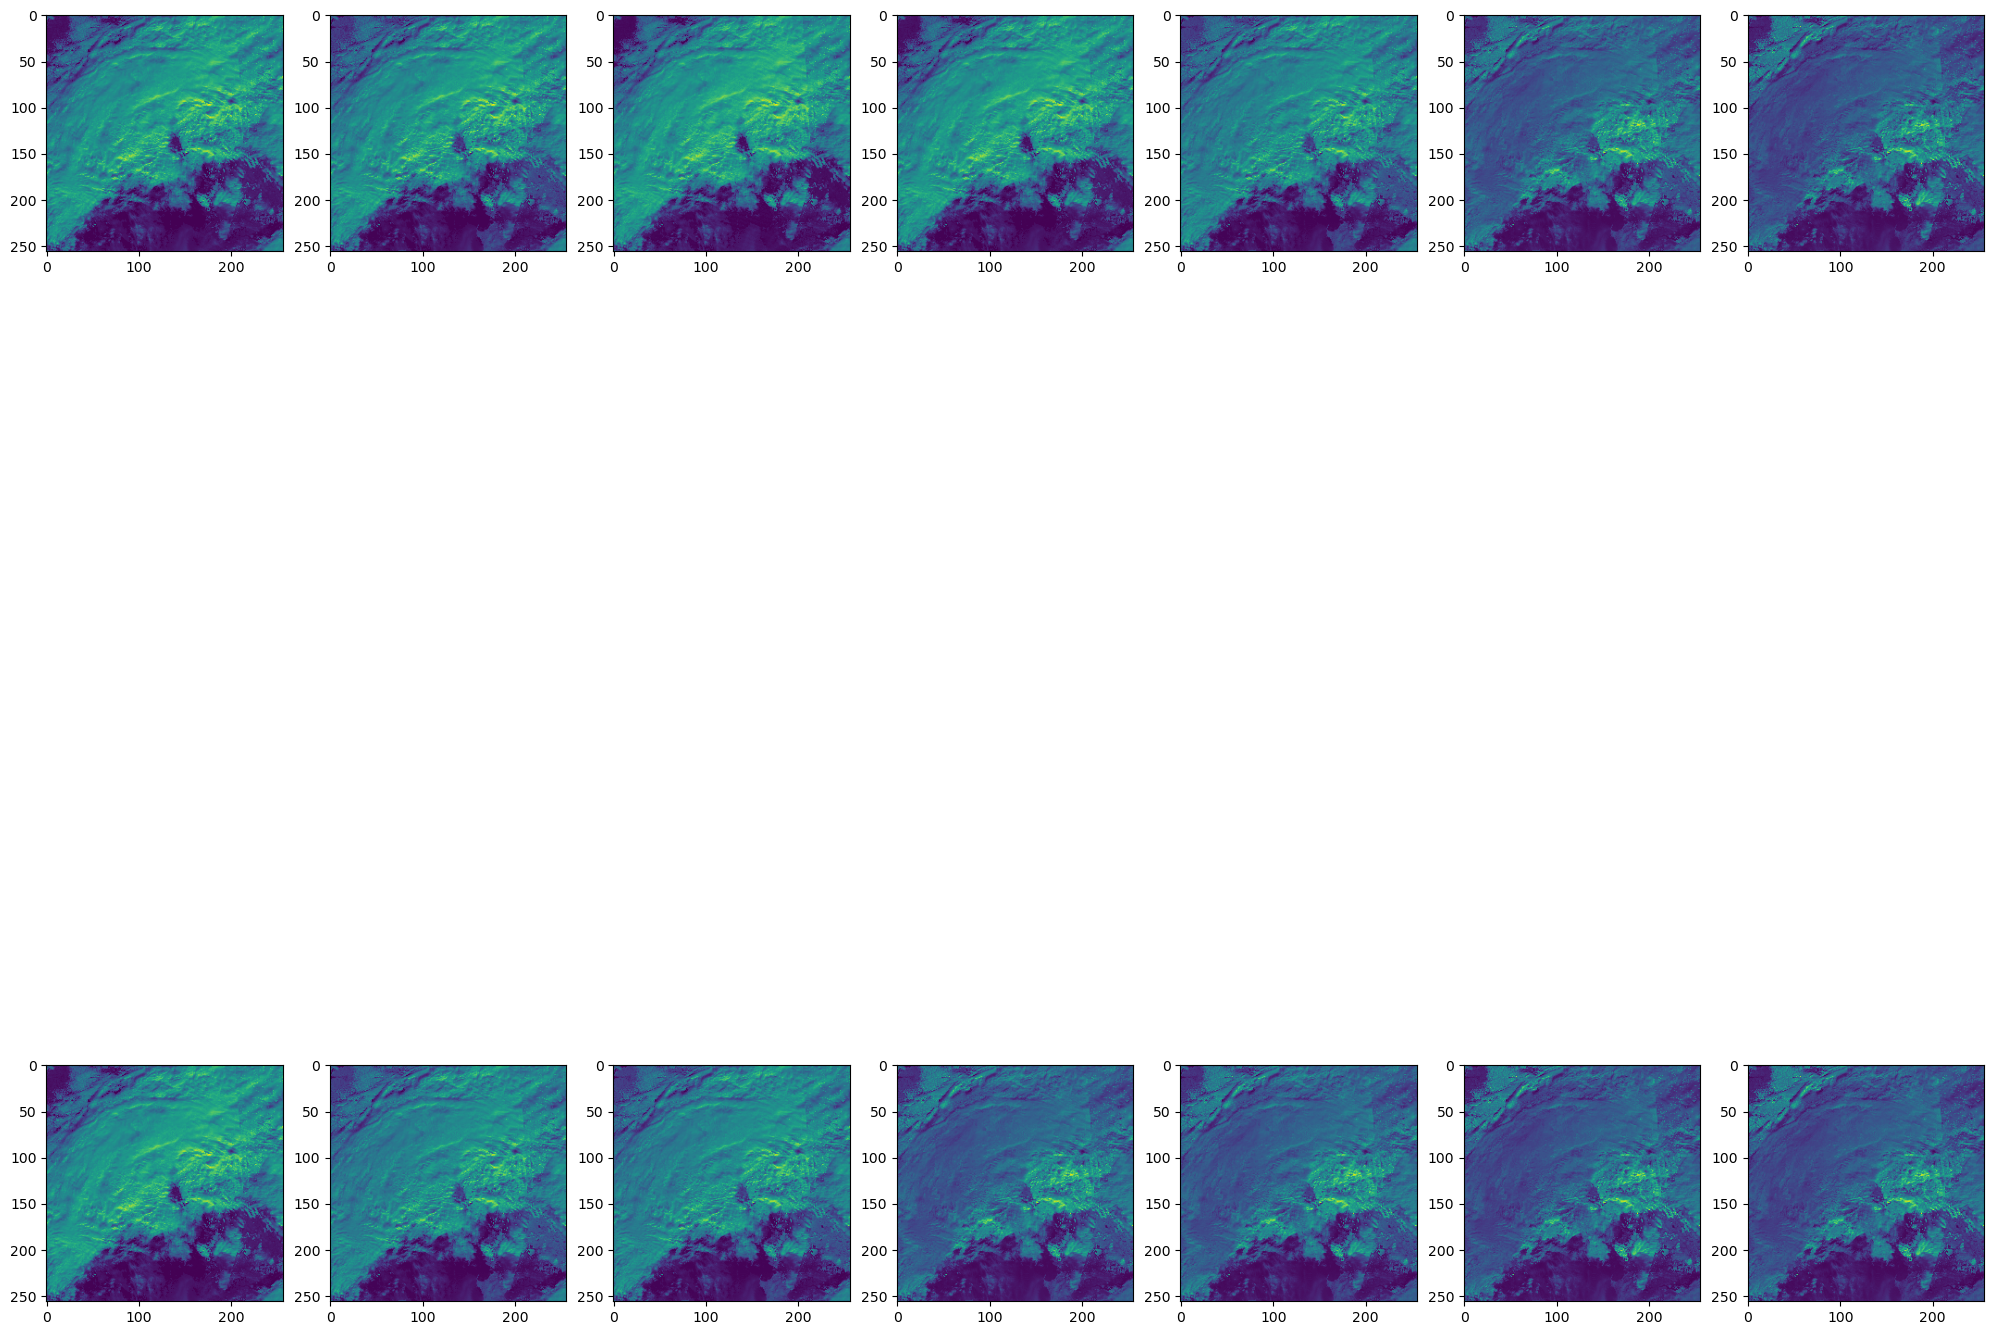

In [157]:
fig, axes = plt.subplots(2,7, figsize=(10,10))
for i, ax in enumerate(axes.flat):
    if i <7:
        ax.imshow(toa_bands_solar[i])
    else: 
        ax.imshow(toa_bands_sensor[i//2])

### Save and test saved image

In [99]:
# getting projection from Subdataset
projection = day1_sur_refl_b05.GetProjection()
projection

'PROJCS["unnamed",GEOGCS["Unknown datum based upon the custom spheroid",DATUM["Not specified (based on custom spheroid)",SPHEROID["Custom spheroid",6371007.181,0]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Sinusoidal"],PARAMETER["longitude_of_center",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["Meter",1],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'

In [100]:
# getting geotransform from subdataset
geo_t = day1_sur_refl_b05.GetGeoTransform()
geo_t

(0.0, 463.3127165279167, 0.0, 5559752.598333, 0.0, -463.31271652750013)

In [36]:
driver = gdal.GetDriverByName("GTiff")
out_raster = driver.Create(f"{modis_path}{day1}_test.tiff", 24, 24, 7, gdal.GDT_Float32)
out_raster.SetProjection(projection)
out_raster.SetGeoTransform(geo_t)
out_raster.FlushCache()
out_raster=None

In [37]:
hi = gdal.Open(f"{modis_path}{day1}_test.tiff")
hi.GetProjection()

'PROJCS["unnamed",GEOGCS["Unknown datum based upon the custom spheroid",DATUM["Not specified (based on custom spheroid)",SPHEROID["Custom spheroid",6371007.181,0]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Sinusoidal"],PARAMETER["longitude_of_center",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'

In [102]:
def np_3D_array_to_tiff(output_path, np_array, projection, geo_transform, no_data_value=15):
    """
    Note: Filename has to end with .tiff (double f)
    """
    if output_path[-5:] != ".tiff":
        output_path += ".tiff"

    np_array[np.isnan(np_array)] = no_data_value

    driver = gdal.GetDriverByName("GTiff")
    out_raster = driver.Create(output_path, np_array.shape[2], np_array.shape[1], np_array.shape[0], gdal.GDT_Float32)
    # where np_array.shape(0) is band amount
    out_raster.SetProjection(projection)
    out_raster.SetGeoTransform(geo_transform)
    
    for i, b in enumerate(np_array):  # np_array has to be sorted (bands) in ascending order
        out_band = out_raster.GetRasterBand(i+1)  # Gdal Rasters start at index 1
        out_band.WriteArray(b)
        # out_band.SetNoDataValue(no_data_value)  # safe?
        out_band.FlushCache()
        out_band = None
    out_raster.FlushCache()
    out_raster = None

In [158]:
toa_bands_solar.shape

(7, 256, 256)

In [159]:
# test np_array_to_tiff
np_3D_array_to_tiff(modis_path+day1+"_TOA.tiff", np_array=toa_bands_solar, projection=projection, geo_transform=geo_t)

In [160]:
np_3D_array_to_tiff(modis_path+day1+"_TOA_256.tiff", np_array=toa_bands_solar, projection=projection, geo_transform=geo_t)

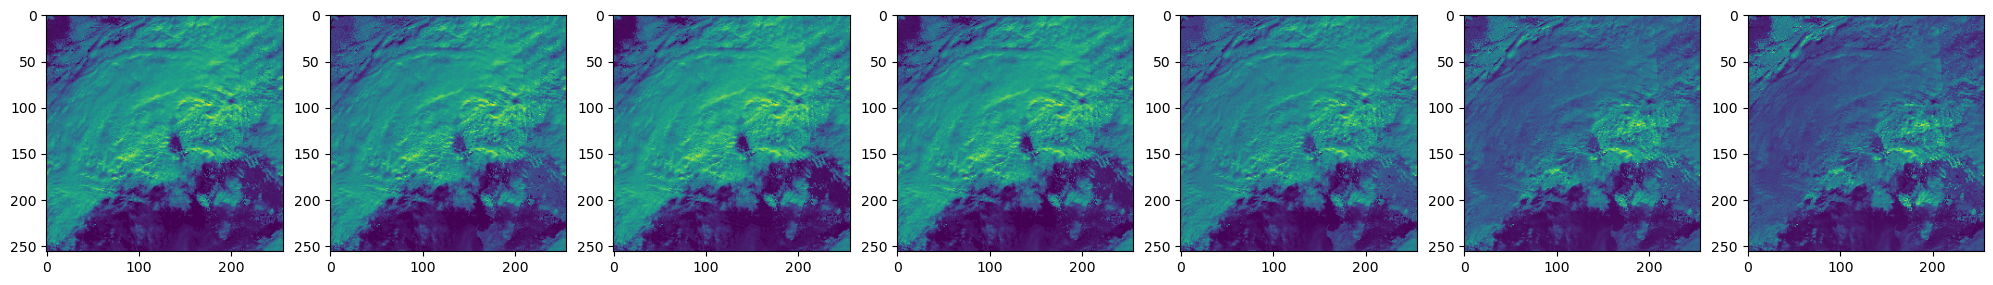

In [161]:
gtiff = gdal.Open(modis_path+day1+"_TOA_256.tiff").ReadAsArray()
fig, axes = plt.subplots(1,7, figsize=(25,25))
for i, ax in enumerate(axes.flat):
    ax.imshow(gtiff[i])

In [162]:
gtiff.shape

(7, 256, 256)

### Translate TOA or merged TIF to (256,256,7) shape

Need to check if MODIS band order correlates to L8 band order. If not, then reorder modis layers...

In [83]:
#toa_256_translate_opts = {"format": "GTiff", "width": "256", "height": "256"}

#gdal.Translate(srcDS=modis_path+day1+"_TOA.tiff", destName=modis_path+day1+"_TOA_256x.tiff",
#               **toa_256_translate_opts)

<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x7f21c2bb2580> >

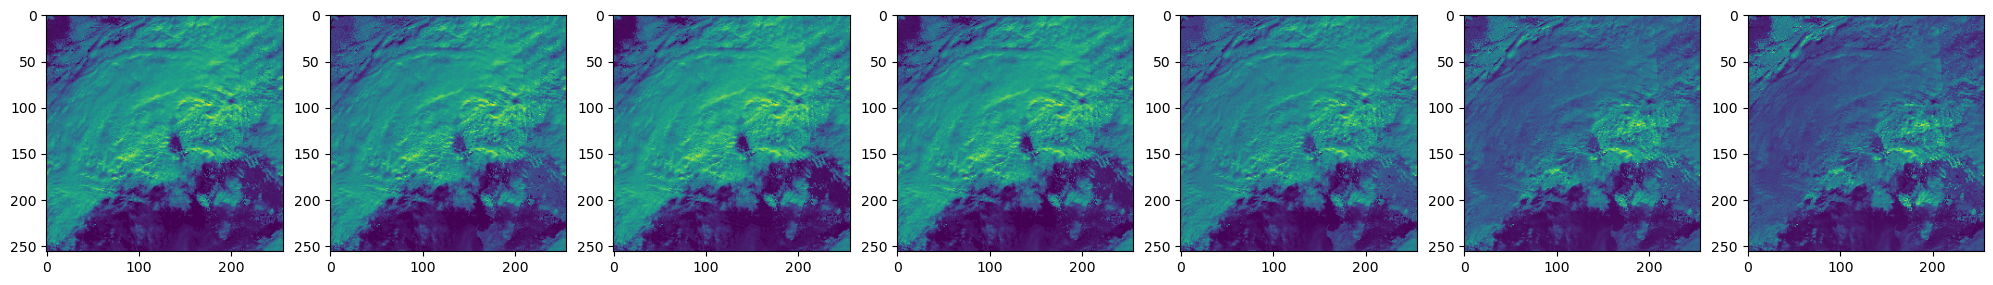

In [163]:
toa_file = gdal.Open(modis_path+day1+"_TOA_256.tiff").ReadAsArray()
fig, axes = plt.subplots(1,7, figsize=(25,25))
for i, ax in enumerate(axes.flat):
    ax.imshow(toa_file[i])

In [164]:
#merged_256_translate_opts = {"format": "GTiff", "width": 256, "height": 256}
#gdal.Translate(srcDS=modis_path+day1+"_merged.tiff", destName=modis_path+day1+"_merged_256x.tiff",
#               **toa_256_translate_opts)

## Aufbereiten einer MODIS-Datei für FMASK

1.1 Mergen zu Merged1-7, dabei Projection + Geometry beibehalten

1.2 Warpen zu _wgs84.tif

2.1 Upscalen der Solar/Sensor Zenith/Azimuth Layers zu 2400x2400 bzw. um Faktor 2,  dabei Projection + Geometry beibehalten

2.2 Warpen zu _wgs84.tif

3. Siehe sis_RunFmaskOnMODIS.ipynb

3.1 Input der Dateien und Bänder-Zuordnung in Fmask Config Objekte

3.2 Run Fmask

4 Upsample der State1km Datei und rewarp zu wgs84

### 1.1

In [ ]:
curr_size = 2400

In [ ]:
merge_MOD09GA_refl_bands_to_tif(modis_path, filename=day1)

0...10...20...30...40...50...60...70...80...90...100 - done.


In [ ]:
# test projection + geometry
f = gdal.Open(modis_path+day1+f"_merged_{curr_size}.tiff")
f.GetGeoTransform()
#f.GetProjection()

(0.0, 463.3127165279167, 0.0, 5559752.598333, 0.0, -463.31271652750013)

### 1.2 

In [ ]:
warp_MOD09GA_to_epsg(modis_path, day1+f"_merged_{curr_size}")

In [ ]:
# test proj, geotransform
f = gdal.Open(modis_path+day1+f"_merged_{curr_size}_wgs84_warped.tiff")
f.GetGeoTransform()
#f.GetProjection()

(0.0,
 0.004844892956886456,
 0.0,
 49.999999995506855,
 0.0,
 -0.004844892956886456)

### 2.1

In [ ]:
# drivers = {"solar_zenith": f'HDF4_EOS:EOS_GRID:"{path}{filename}.hdf":MODIS_Grid_1km_2D:SolarZenith_1',
#                "solar_azimuth": f'HDF4_EOS:EOS_GRID:"{path}{filename}.hdf":MODIS_Grid_1km_2D:SolarAzimuth_1',
#                "sensor_zenith": f'HDF4_EOS:EOS_GRID:"{path}{filename}.hdf":MODIS_Grid_1km_2D:SensorZenith_1',
#                "sensor_azimuth": f'HDF4_EOS:EOS_GRID:"{path}{filename}.hdf":MODIS_Grid_1km_2D:SensorAzimuth_1'}

In [ ]:
upscale_all_angle_layers(modis_path, day1, size=curr_size)
# output is: MOD09GA.A2023335.h18v04.061.2023340033530_upscaled_angles_2400.tiff

0...10...20...30...40...50...60...70...80...90...100 - done.


In [ ]:
# test proj, geotransform
f = gdal.Open(modis_path+f'MOD09GA.A2023335.h18v04.061.2023340033530_upscaled_angles_{curr_size}.tiff')
f.GetGeoTransform()
f.GetProjection()

'PROJCS["unnamed",GEOGCS["Unknown datum based upon the custom spheroid",DATUM["Not_specified_based_on_custom_spheroid",SPHEROID["Custom spheroid",6371007.181,0]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Sinusoidal"],PARAMETER["longitude_of_center",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'

### 2.2

In [ ]:
warp_MOD09GA_to_wgs84(modis_path, filename=day1+f"_upscaled_angles_{curr_size}")

In [ ]:
# also warp all individual angle files, for Fmask AnglesFileInfo input
angles = ["solar_zenith", "solar_azimuth", "sensor_zenith", "sensor_azimuth"]

for a in angles:
    warp_MOD09GA_to_wgs84(modis_path, filename=day1+"_"+a+"_"+str(curr_size))

In [ ]:
# test result

In [ ]:
f = gdal.Open(modis_path+f'MOD09GA.A2023335.h18v04.061.2023340033530_upscaled_angles_{curr_size}_wgs84_warped.tiff')
f.GetGeoTransform()
f.GetProjection()

'GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]'

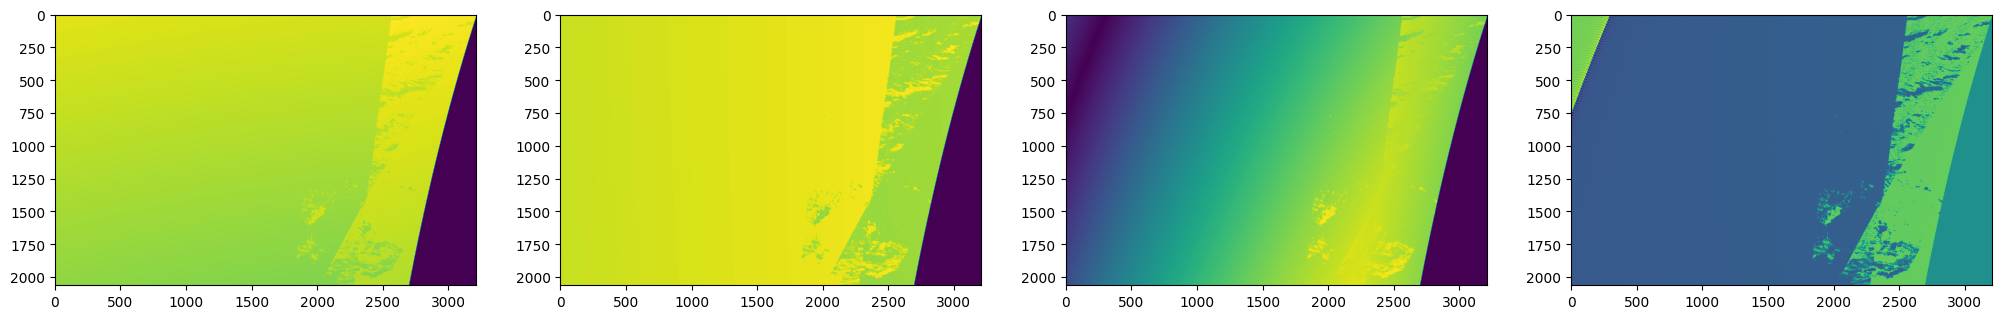

In [ ]:
fig, axes = plt.subplots(1,4, figsize=(25,25))

for i, ax in enumerate(axes.flat):
    ax.imshow(f.ReadAsArray()[i])

### 3 
Siehe sis_RunFmaskOnMODIS notebook

### 4 
Warp and NN/CUBIC-Upsample-Resample STATE_1KM to WGS84

In [ ]:
day = day1
driver = f'HDF4_EOS:EOS_GRID:"{modis_path}{day}.hdf":MODIS_Grid_1km_2D:state_1km_1'
upscale_single_layer(modis_path, day, name="state_1km_1", driver=driver, size=curr_size)

In [ ]:
gdal.Open(modis_path+ day+"_state_1km_1_2400.tiff").ReadAsArray().shape

(2400, 2400)

In [ ]:
warp_MOD09GA_to_epsg(modis_path, day+"_state_1km_1_2400")